In [1]:
import warnings


import pandas as pd

import pylab as pl
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import preprocessing
from sklearn import cross_validation

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
#defining function to read data 
def read_training_data(data_files):
    
    age_gender = pd.read_csv(data_files['age_gender'])
    countries = pd.read_csv(data_files['countries'])
    sessions = pd.read_csv(data_files['sessions'])
    train_users = pd.read_csv(data_files['users'])
    
    return age_gender, countries, sessions, train_users

#def

In [3]:
data_files = {'age_gender':'data/age_gender_bkts.csv',
'countries':'data/countries.csv',
'sessions':'data/sessions.csv',
'users':'data/train_users_2.csv'}

In [4]:
#general data wrangling
def clean_up(dataframe):

    #dealing with missing data
    dataframe.replace("-unknown-", np.nan, inplace = True)
    new_timestamp = dataframe.timestamp_first_active.astype(str)
    dates = pd.to_datetime(pd.Series([datetime.strptime(date, '%Y%m%d%H%M%S') for date in new_timestamp]))
    
    # replace age in areas where it doesn't make sense with -1
    av = dataframe.age.values
    dataframe['age'] = np.where(np.logical_or(av<14, av>100), -1, av)
    
    #replacing datetime objects which are more difficult to work with
    dataframe['timestamp_first_active'] = dates
    dataframe['date_account_created'] = pd.to_datetime(dataframe.date_account_created)
    dataframe['date_first_booking'] = pd.to_datetime(dataframe.date_first_booking)
    dataframe.rename(columns = {'id':'user_id'}, inplace = True)
    df = dataframe.merge(sessions, on = 'user_id', how = 'left')
    user_ids = df['user_id']
    df_2 = df.drop('user_id', axis = 1)
    
    #sepparating in order to have numerical values for each
    
    #date_account_created
    df_2['dac_year'] = df_2.date_account_created.dt.year
    df_2['dac_month'] = df_2.date_account_created.dt.month
    df_2['dac_day'] = df_2.date_account_created.dt.day

    #timestamp_first_active
    df_2['tfa_year'] = df_2.timestamp_first_active.dt.year
    df_2['tfa_month'] = df_2.timestamp_first_active.dt.month
    df_2['tfa_day'] = df_2.timestamp_first_active.dt.day

    #dropping timestamps from model
    df_2 = df_2.drop(['date_account_created','timestamp_first_active','date_first_booking'],axis = 1)
    
    
    #condition to check if it's the training set or test set
    if 'country_destination' in list(df_2.columns):

        labels = df_2.country_destination
        df_2 = df_2.drop('country_destination', axis = 1)
        
        print df_2.shape[0], user_ids.shape[0] 
        return df_2, labels, user_ids, df_2.columns
        
    else:
        print df_2.shape[0], user_ids.shape[0] 
        return df_2, user_ids, df_2.columns
    
    #if

#def

def encode_df(df_in,feature_list):
    
    #encoding all the non-numerical variables
    
    le = preprocessing.LabelEncoder()
    
    for item in feature_list:
        le.fit(df_in[item])
        encoded = le.transform(df_in[item])
        df_in[item] = encoded
    #for
    
    df_in = df_in.fillna(-1)
    
    return df_in

#def

def preprocessing_df(df_in,mode,normalizers=None):
    
    #
    # normalising the rest of the variables
    #
    
    if mode == 'train':
        scaler = preprocessing.MinMaxScaler().fit(df_in)
        df_in= scaler.transform(df_in)
        normalizers = scaler
        return df_in, normalizers
    elif mode == 'test':
        df_in = normalizers.transform(df_in)
        return df_in
    else:
        print 'Mode not defined {}'.format(mode)
    #if
    
#def

In [5]:
feature_list = ['gender','signup_method','language','affiliate_channel',
         'affiliate_provider','first_affiliate_tracked','affiliate_provider',
         'first_affiliate_tracked','signup_app','first_device_type','first_browser','action',
        'action_type','action_detail','device_type']

### Reading all the data
****

In [6]:
age_gender, countries, sessions, train_users = read_training_data(data_files)

### Preprocessing train data
****


In [7]:
train_set, train_labels, train_user_id, column_names_train = clean_up(train_users)

5677593 5677593


In [8]:
train_set = encode_df(train_set, feature_list)
train_set.shape[0]

5677593

In [9]:
train_set, normalizers = preprocessing_df(train_set,'train',normalizers=None)

In [10]:
encoded_dummies = pd.get_dummies(train_labels)
#encoded_dummies = pd.get_dummies(train_labels).as_matrix()
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
train_labels_set = le.fit_transform(train_labels)
train_labels_set


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Reducing Dimensionality
****

In [11]:
from time import time
from sklearn.decomposition import RandomizedPCA
n_components = 15

print "Extracting the top %d features from %d rows" % (n_components, train_set.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(train_set)
print "done in %0.3fs" % (time() - t0)

#eigenvalues = pca.components_.reshape((n_components, X_train.shape[0],  X_train.shape[1]))

print "Projecting the input data on the eigenvalues orthonormal basis"
t0 = time()
X_train_pca = pca.transform(train_set)
#X_test_pca = pca.transform(test_set)
print "done in %0.3fs" % (time() - t0)



Extracting the top 15 features from 5677593 rows
done in 28.612s
Projecting the input data on the eigenvalues orthonormal basis
done in 1.806s


### Splitting Training Data - train and CV
****

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_pca, train_labels_set, test_size=0.3, random_state=0)

In [13]:
print "training: %i, %i" % (X_train.shape[0],y_train.shape[0])
print "test: %i, %i" % (X_test.shape[0],y_test.shape[0])

training: 3974315, 3974315
test: 1703278, 1703278


### Training phase
****

In [15]:
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [51]:
clf = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_jobs = -1,class_weight='balanced',oob_score=True))

In [52]:
t0 = time()
clf.fit(X_train, y_train)
print "done in %0.3fs" % (time() - t0)

done in 2521.315s


In [53]:
y_pred = clf.predict(X_test)

In [54]:
clf.score(X_test, y_test)

0.89437014979351581

[ 0.13486876  0.11418262  0.09165925  0.13495661  0.09786402  0.0677032
  0.05535946  0.06121418  0.04531642  0.06550279  0.03761088  0.03274269
  0.02351779  0.02051479  0.01698653]
Feature ranking:
1. feature 2 (0.134957)
2. feature 4 (0.134869)
3. feature 11 (0.114183)
4. feature 7 (0.097864)
5. feature 13 (0.091659)
6. feature 5 (0.067703)
7. feature 12 (0.065503)
8. feature 8 (0.061214)
9. feature 3 (0.055359)
10. feature 9 (0.045316)
11. feature 14 (0.037611)
12. feature 0 (0.032743)
13. feature 1 (0.023518)
14. feature 6 (0.020515)
15. feature 10 (0.016987)


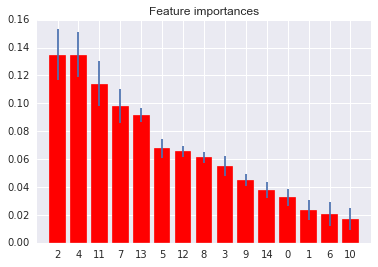

[ 0.12126923  0.11669184  0.08905396  0.09272354  0.10263367  0.07542169
  0.06526214  0.05916222  0.0558603   0.05987817  0.04280648  0.0369019
  0.0310964   0.02834154  0.02289692]
Feature ranking:
1. feature 2 (0.121269)
2. feature 4 (0.116692)
3. feature 13 (0.102634)
4. feature 7 (0.092724)
5. feature 11 (0.089054)
6. feature 5 (0.075422)
7. feature 12 (0.065262)
8. feature 9 (0.059878)
9. feature 8 (0.059162)
10. feature 3 (0.055860)
11. feature 14 (0.042806)
12. feature 0 (0.036902)
13. feature 1 (0.031096)
14. feature 6 (0.028342)
15. feature 10 (0.022897)


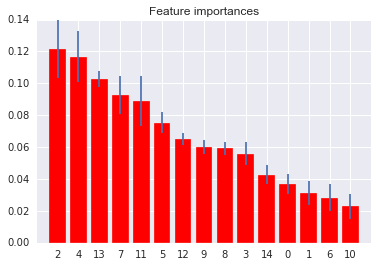

[ 0.13120297  0.11367316  0.08540214  0.08842531  0.09358455  0.07345145
  0.05471388  0.05837453  0.06435552  0.0726207   0.03698938  0.04690117
  0.03343364  0.02501452  0.02185708]
Feature ranking:
1. feature 2 (0.131203)
2. feature 4 (0.113673)
3. feature 11 (0.093585)
4. feature 7 (0.088425)
5. feature 13 (0.085402)
6. feature 5 (0.073451)
7. feature 3 (0.072621)
8. feature 8 (0.064356)
9. feature 9 (0.058375)
10. feature 12 (0.054714)
11. feature 0 (0.046901)
12. feature 14 (0.036989)
13. feature 1 (0.033434)
14. feature 6 (0.025015)
15. feature 10 (0.021857)


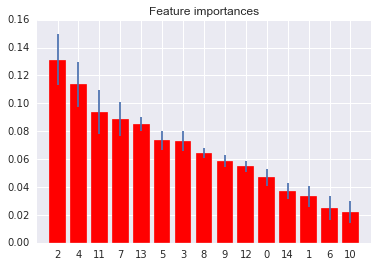

[ 0.13730901  0.10362122  0.07181686  0.09217499  0.08881987  0.06766279
  0.06478396  0.06654701  0.05980515  0.06130446  0.04500291  0.04360137
  0.03747553  0.03175664  0.02831823]
Feature ranking:
1. feature 2 (0.137309)
2. feature 4 (0.103621)
3. feature 7 (0.092175)
4. feature 13 (0.088820)
5. feature 11 (0.071817)
6. feature 5 (0.067663)
7. feature 8 (0.066547)
8. feature 3 (0.064784)
9. feature 12 (0.061304)
10. feature 9 (0.059805)
11. feature 0 (0.045003)
12. feature 14 (0.043601)
13. feature 1 (0.037476)
14. feature 6 (0.031757)
15. feature 10 (0.028318)


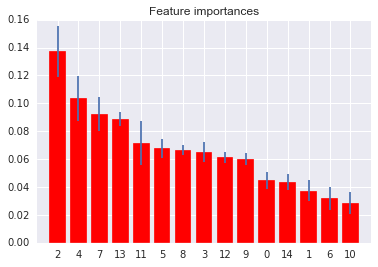

[ 0.12484833  0.10320293  0.09013066  0.09171222  0.0694732   0.07283127
  0.06295477  0.06855944  0.05936073  0.05609016  0.04407055  0.04383196
  0.04500198  0.03732992  0.0306019 ]
Feature ranking:
1. feature 2 (0.124848)
2. feature 4 (0.103203)
3. feature 13 (0.091712)
4. feature 7 (0.090131)
5. feature 5 (0.072831)
6. feature 11 (0.069473)
7. feature 3 (0.068559)
8. feature 8 (0.062955)
9. feature 12 (0.059361)
10. feature 9 (0.056090)
11. feature 1 (0.045002)
12. feature 0 (0.044071)
13. feature 14 (0.043832)
14. feature 6 (0.037330)
15. feature 10 (0.030602)


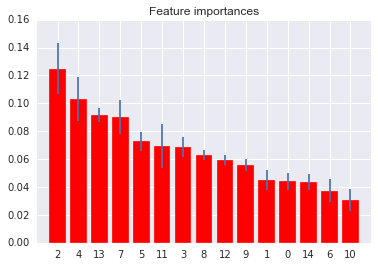

[ 0.13061802  0.11125869  0.09907748  0.09147831  0.07789148  0.06431525
  0.07381513  0.06419372  0.0608651   0.05729037  0.03469537  0.03765453
  0.04146301  0.02989158  0.02549197]
Feature ranking:
1. feature 2 (0.130618)
2. feature 4 (0.111259)
3. feature 13 (0.099077)
4. feature 7 (0.091478)
5. feature 5 (0.077891)
6. feature 3 (0.073815)
7. feature 11 (0.064315)
8. feature 8 (0.064194)
9. feature 12 (0.060865)
10. feature 9 (0.057290)
11. feature 14 (0.041463)
12. feature 0 (0.037655)
13. feature 1 (0.034695)
14. feature 6 (0.029892)
15. feature 10 (0.025492)


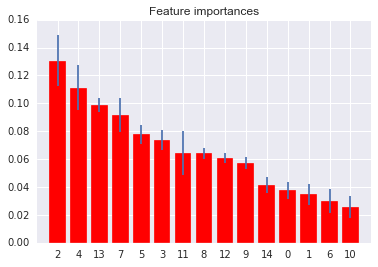

[ 0.13098151  0.09721749  0.08848319  0.09584301  0.07460945  0.06748593
  0.06986251  0.06595618  0.06113649  0.06127163  0.0459394   0.03899026
  0.04061864  0.0329836   0.02862072]
Feature ranking:
1. feature 2 (0.130982)
2. feature 4 (0.097217)
3. feature 7 (0.095843)
4. feature 13 (0.088483)
5. feature 5 (0.074609)
6. feature 11 (0.069863)
7. feature 3 (0.067486)
8. feature 8 (0.065956)
9. feature 9 (0.061272)
10. feature 12 (0.061136)
11. feature 14 (0.045939)
12. feature 1 (0.040619)
13. feature 0 (0.038990)
14. feature 6 (0.032984)
15. feature 10 (0.028621)


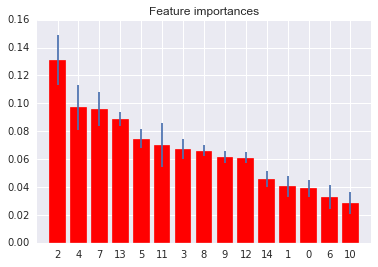

[ 0.07871993  0.13676597  0.0635701   0.09698548  0.05790904  0.10805398
  0.05900094  0.05495245  0.05407447  0.05374322  0.05204677  0.04826277
  0.0505222   0.04545255  0.03994013]
Feature ranking:
1. feature 4 (0.136766)
2. feature 11 (0.108054)
3. feature 13 (0.096985)
4. feature 2 (0.078720)
5. feature 7 (0.063570)
6. feature 3 (0.059001)
7. feature 5 (0.057909)
8. feature 8 (0.054952)
9. feature 9 (0.054074)
10. feature 12 (0.053743)
11. feature 14 (0.052047)
12. feature 0 (0.050522)
13. feature 1 (0.048263)
14. feature 6 (0.045453)
15. feature 10 (0.039940)


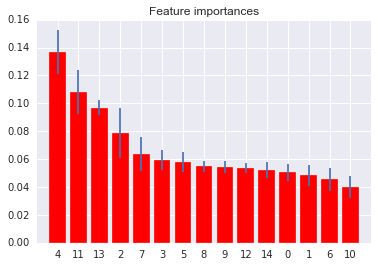

[ 0.10259754  0.08224894  0.08846636  0.13493019  0.09412002  0.0717082
  0.07930973  0.06936825  0.06025989  0.06277777  0.03459356  0.03349784
  0.03636162  0.02661948  0.0231406 ]
Feature ranking:
1. feature 2 (0.134930)
2. feature 4 (0.102598)
3. feature 7 (0.094120)
4. feature 13 (0.088466)
5. feature 11 (0.082249)
6. feature 5 (0.079310)
7. feature 3 (0.071708)
8. feature 8 (0.069368)
9. feature 12 (0.062778)
10. feature 9 (0.060260)
11. feature 1 (0.036362)
12. feature 14 (0.034594)
13. feature 0 (0.033498)
14. feature 6 (0.026619)
15. feature 10 (0.023141)


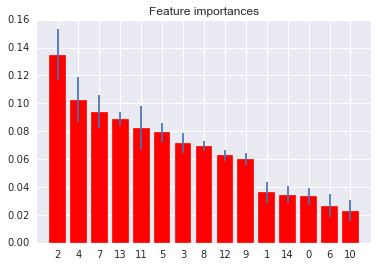

[ 0.12355086  0.08060222  0.10960439  0.09575352  0.09810424  0.08199367
  0.07634045  0.06306747  0.06313725  0.05319085  0.02943876  0.03772532
  0.05063169  0.02094147  0.01591783]
Feature ranking:
1. feature 2 (0.123551)
2. feature 7 (0.109604)
3. feature 11 (0.098104)
4. feature 13 (0.095754)
5. feature 5 (0.081994)
6. feature 4 (0.080602)
7. feature 3 (0.076340)
8. feature 12 (0.063137)
9. feature 8 (0.063067)
10. feature 9 (0.053191)
11. feature 0 (0.050632)
12. feature 14 (0.037725)
13. feature 1 (0.029439)
14. feature 6 (0.020941)
15. feature 10 (0.015918)


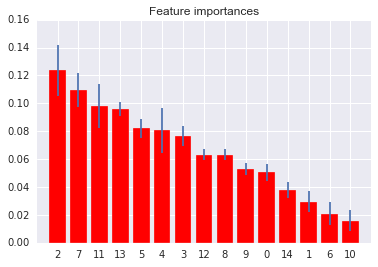

[ 0.08611908  0.06686745  0.09779246  0.09398233  0.06145927  0.13152959
  0.05746494  0.05493919  0.05717938  0.05671936  0.04855583  0.05278587
  0.04795694  0.0458396   0.04080872]
Feature ranking:
1. feature 4 (0.131530)
2. feature 11 (0.097792)
3. feature 13 (0.093982)
4. feature 2 (0.086119)
5. feature 7 (0.066867)
6. feature 5 (0.061459)
7. feature 3 (0.057465)
8. feature 8 (0.057179)
9. feature 9 (0.056719)
10. feature 12 (0.054939)
11. feature 14 (0.052786)
12. feature 0 (0.048556)
13. feature 1 (0.047957)
14. feature 6 (0.045840)
15. feature 10 (0.040809)


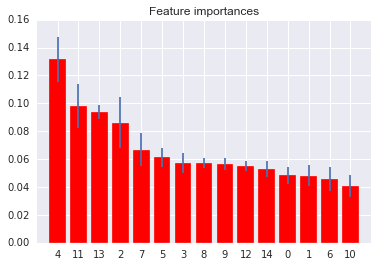

In [82]:
#plotting importances at each class
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = {}
for i in range(0,len(clf.estimators_)-1):
    importances = clf.estimators_[i].feature_importances_
    print importances[indices]
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    x = {}
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        x[f+1] = indices[f]

    # Plot the feature importances of the forest
    plt.figure()
    y[i] = x
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [42]:
from sklearn import metrics

print metrics.f1_score(y_test, y_pred)
print metrics.accuracy_score(y_test, y_pred)

0.917366546806
0.894370149794


In [67]:
pd.DataFrame(X_train_pca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.594901,1.463548,0.940211,1.454784,-0.551258,-0.404513,1.003129,-0.476056,0.916723,1.880693,-1.724584,1.736655,-1.119336,-0.776259,5.319796
1,1.893048,1.045996,0.966610,1.257926,1.480909,0.277361,0.990586,-1.549775,2.277873,-0.902830,-2.252592,0.256299,-0.653628,-1.095170,4.751448
2,1.525645,1.546143,0.376014,0.742833,0.401928,-0.497665,1.432482,0.921868,2.032830,1.446543,-1.887109,-1.578339,1.796891,0.790341,5.754475
3,1.651724,1.420745,0.285081,1.492247,0.843464,-0.013893,1.662599,1.094943,3.765502,2.404817,-1.371373,0.569758,-0.013563,0.595836,4.190602
4,1.583162,1.542643,-0.513586,1.186846,-0.581215,-0.177780,1.786191,0.481745,3.649380,2.629940,-1.193479,-1.222684,0.011681,1.467729,4.864033


In [80]:
pd.DataFrame(train_set)[11].head()

0    0
1    0
2    0
3    0
4    0
Name: 11, dtype: float64

# Process Again
****

In [43]:
print train_users.shape[0], train_set.shape[0]

213451 5677593


### Reading Test Data
****

In [44]:
test_users = pd.read_csv('data/test_users.csv')
test_set, test_user_id, column_names_test = clean_up(test_users)


4995712 4995712


In [45]:
test_set = encode_df(test_set, feature_list)
test_set = preprocessing_df(test_set, 'test', normalizers = normalizers)
test_set.shape[0]

4995712

In [46]:
X_test_pca = pca.transform(test_set)

In [47]:
X_test_pca.shape

(4995712, 15)

In [49]:
#training on the entire train set
t0 = time()
clf = OneVsRestClassifier(RandomForestClassifier(bootstrap = True, random_state=0, n_jobs = -1,class_weight='balanced',oob_score=True))
print "done in %0.3fs" % (time() - t0)

t0= time()
clf.fit(X_train_pca, train_labels_set)
print "done in %0.3fs" % (time() - t0)

t0 = time()
#predict probabilities of each country
y_pred = clf.predict_proba(X_test_pca)
print "done in %0.3fs" % (time() - t0)

done in 0.000s


KeyboardInterrupt: 

In [30]:
y_pred.shape[0]

4995712

### Submission format
****

In [31]:
#since the predictions need to be on a user level, we need to average out the probabilities
last_df = pd.concat([test_user_id,pd.DataFrame(y_pred, columns = encoded_dummies.columns)], axis = 1)
last_df = last_df.groupby('user_id').mean().reset_index()

last_df.head()


,user_id,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
0,0010k6l0om,0.000000,0.061905,0.000000,0.023810,0.085714,0.000000,0.076190,0.690476,0.000000,0.000000,0.303175,0.107937
1,0031awlkjq,0.000000,0.025000,0.000000,0.050000,0.037500,0.000000,0.037500,0.487500,0.050000,0.037500,0.250000,0.181250
2,00378ocvlh,0.000000,0.012000,0.002667,0.017333,0.057333,0.000000,0.072000,0.640000,0.001333,0.000000,0.392000,0.041333
3,0048rkdgb1,0.030435,0.034938,0.023913,0.034783,0.043478,0.139298,0.005797,0.555694,0.006522,0.004348,0.397021,0.097911
4,0057snrdpu,0.007143,0.010714,0.035714,0.057143,0.021429,0.064286,0.000000,0.614286,0.150000,0.000000,0.335714,0.067857


In [34]:
import operator

ids = []
result = {}
for index, row in last_df.iterrows():
    country_values = row[1:].to_dict()
    sorted_vals = sorted(country_values.items(), key=operator.itemgetter(1), reverse = True)[:5]
    result[row[0]]= sorted_vals

In [35]:
some_other_df = pd.DataFrame(result).T
some_other_df.head()

,0,1,2,3,4
0010k6l0om,"(NDF, 0.690476190476)","(US, 0.303174603175)","(other, 0.107936507937)","(FR, 0.0857142857143)","(IT, 0.0761904761905)"
0031awlkjq,"(NDF, 0.4875)","(US, 0.25)","(other, 0.18125)","(NL, 0.05)","(ES, 0.05)"
00378ocvlh,"(NDF, 0.64)","(US, 0.392)","(IT, 0.072)","(FR, 0.0573333333333)","(other, 0.0413333333333)"
0048rkdgb1,"(NDF, 0.555693581781)","(US, 0.397020933977)","(GB, 0.139297658863)","(other, 0.0979113384484)","(FR, 0.0434782608696)"
0057snrdpu,"(NDF, 0.614285714286)","(US, 0.335714285714)","(NL, 0.15)","(other, 0.0678571428571)","(GB, 0.0642857142857)"


In [36]:
pd.DataFrame(some_other_df.unstack(0))\
.reset_index()\
.sort_values(['level_1','level_0'])[['level_1',0]].to_csv('something.csv', index = False)

### This returns a score of 84.86% accuracy on the website